[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nasa-gcn/circulars-nlp-paper/blob/main/topic-modeling/notebooks/unsupervised_astrophysical_topics.ipynb)


#**Unsupervised Topic Modeling of NASA GCN Circulars with BERTopic**

The [General Coordinates Network (GCN) Circulars](https://gcn.nasa.gov/circulars) serve as a real-time communication platform for the astrophysics community, enabling the rapid dissemination of discoveries such as gamma-ray bursts, gravitational-wave events, neutrino detections, and other transient phenomena. With three decades of accumulated data spanning more than forty thousands of Circulars, this archive serve as rich scientific resource. However, the unstructured and rapidly written nature of these reports makes systematic analysis and organization challenging.

This project aims to leverage BERTopic, a state-of-the-art transformer-powered topic modeling framework, to automatically identify, cluster, and summarize the major themes within the GCN circular database. By combining:
- **SentenceTransformers** for semantic embeddings  
- **UMAP** for dimensionality reduction  
- **HDBSCAN** for unsupervised clustering  
- **LLMs (e.g., Mistral 7B)** for human-readable topic labels  

This pipeline different research themes, and scientific trends in GCN circulars.

## ⚙️ Setup Instructions

- This notebook is designed for **Google Colab**.  
- Before running, create a free [HuggingFace account](https://huggingface.co/) and generate an access token.  
- Store the token in **Colab’s Secrets** as `HF_LOGIN_TOKEN` and enable notebook access (guide: [Using secrets in Colab](https://drlee.io/how-to-use-secrets-in-google-colab-for-api-key-protection-a-guide-for-openai-huggingface-and-c1ec9e1277e0)).  


## ⚠️ Runtime Notes

- For reproducible results, **run all cells sequentially and only once**.  
- Re-running without restarting the runtime may lead to small variations due to the stochastic nature of **UMAP** and **HDBSCAN**.  
- We recommend using **Colab’s L4 GPU runtime** (available with Colab Pro, ~$10/month), which was used in our outputs. Other GPU runtimes will also work but may yield slight deviations.  

#Step 1: Download Data and Install necessary libraries

In [1]:
# Download the data and stopwords (uncomment to run in Colab)
# If you already uploaded the files to /content, you can skip this cell.

!wget https://raw.githubusercontent.com/nasa-gcn/circulars-nlp-paper/main/data/archive_2025.json.tar.gz -O /content/archive_2025.json.tar.gz
!wget https://raw.githubusercontent.com/nasa-gcn/circulars-nlp-paper/main/data/custom_stopwords.txt -O /content/custom_stopwords.txt
print("Downloaded archive_2025.json.tar.gz and custom_stopwords.txt to /content")

--2025-10-07 02:03:11--  https://raw.githubusercontent.com/nasa-gcn/circulars-nlp-paper/main/data/archive_2025.json.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27323287 (26M) [application/octet-stream]
Saving to: ‘/content/archive_2025.json.tar.gz’

/content/archive_20 100%[===================>]  26.06M   156MB/s    in 0.2s    

2025-10-07 02:03:13 (156 MB/s) - ‘/content/archive_2025.json.tar.gz’ saved [27323287/27323287]

--2025-10-07 02:03:13--  https://raw.githubusercontent.com/nasa-gcn/circulars-nlp-paper/main/data/custom_stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443.

In [2]:
# Install dependencies (run once)
# NOTE: these installs might take a ~10 minutes in Colab for T4 GPU.

%pip install bertopic==0.16.2 -qqq
!CMAKE_ARGS="-DGGML_CUDA=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.3.9 -qqq
!wget https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/resolve/main/mistral-7b-instruct-v0.2.Q4_K_M.gguf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.4 MB/s eta 0:00:00
--2025-10-07 02:32:55--  https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/resolve/main/mistral-7b-instruct-v0.2.Q4_K_M.gguf
Resolving huggingface.co (huggingface.co)... 13.35.202.40, 13.35.202.121, 13.35.202.97, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.40|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cas-bridge.xethub.hf.co/xet-bridge-us/65778ac662d3ac1817cc9201/865f5e4682dddb29c2e20270b2471a7590c83a414bbf1d72cf4c08fdff2eeca4?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Content-Sha256=UNSIGNED-PAYLOAD&X-Amz-Cre

#Step 2: Extract GCN Circulars

In [3]:
'''
(a) Extract circular JSONs from tar file.
(b) Extract circular bodies from JSON list.
'''
import tarfile
import json
import os

with tarfile.open('./archive_2025.json.tar.gz', 'r') as file:
  file.extractall(path='./all_gcn_circulars')

dir = os.listdir('./all_gcn_circulars/archive.json') #Store all file names as strings in dir

#Add file path to beginning of file names in dir
dir = ['./all_gcn_circulars/archive.json/' + filename for filename in sorted(dir)]

print(f'Number of Circular JSONs: {len(dir)}\n')
print(f'First JSON path is: {dir[0]}')


circulars = []
circular_bodies = []
time_stamps = []
for file in dir:
  with open(file, encoding='utf-8') as f:
    data = json.load(f)
    circulars.append(data)
    circular_bodies.append(data["subject"]+data["body"])
    time_stamps.append(data["createdOn"])

print(f'The first circular is:\n {circulars[0]}\n')
print(f'The first circular body is:\n {circular_bodies[0]}')

'''
Remove all undefined characters.
'''

clean_texts = []
for text in circular_bodies:
  clean_text = text.replace('�', '')
  clean_texts.append(clean_text)

circular_bodies = clean_texts

/tmp/ipython-input-442236234.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  file.extractall(path='./all_gcn_circulars')


Number of Circular JSONs: 40506

First JSON path is: ./all_gcn_circulars/archive.json/-1.json
The first circular is:
 {'subject': 'Possible new SGR from US Naval Observatory', 'editedOn': 1720124028651, 'version': 4, 'createdOn': 874022400000, 'editedBy': 'Vidushi Sharma at NASA GSFC/UMBC <vidushi.sharma@nasa.gov> on behalf of Tyler Barna at University of Minnesota <tylerpbarna@gmail.com>', 'submitter': 'Arne A. Henden at USNO/USRA <aah@nofs.navy.mil>', 'circularId': -1, 'email': 'circulars@gcn.nasa.gov', 'format': 'text/plain', 'body': 'The following report from A. Hendon et al. on the recent "possible new SGR"\n(ref IAUC 6743) has also been submitted to the IAUC:\n\n\nA. Henden, Universities Space Research Corporation (USRA) and U. S. Naval\nObservatory, Flagstaff Station (USNOFS)  aah@nofs.navy.mil\nC. Luginbuhl, USNOFS  cbl@nofs.navy.mil\nF. Vrba, USNOFS       fjv@nofs.navy.mil\nB. Canzian, USRA/USNOFS  bjc@nofs.navy.mil\nJ. Munn USNOFS           jam@nofs.navy.mil\nD. Hartmann, Cle

#Step 3: Create Custom Stopwords List

In [5]:
'''
We will remove common English stopwords, punctuations, numbers, emails, and urls for preliminary statistical analysis and topic representations.
We will also remove a hand-selected list of stopwords that do not add any value to our representations.
As BERT uses a transformer based embedding model, it requires stopwords to build accurate embeddings.
So removing stopwords before this step is unadvised.
However, we can remove stopwords after embedding and clustering.
We will use sklearn's WordVectorizer for this.
'''
import nltk
from nltk.corpus import stopwords
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords') # NLTK package for stopwords list

new_stop_words = []
new_stop_words = stopwords.words('english') #NLTK standard list of stopwords
punctuation_list = list(string.punctuation) #Standard list of punctuations
new_stop_words.extend(punctuation_list)

# Get list of numbers and urls in circulars
num_list = []
url_list = []
http_regex = re.compile(r"http.*")

for text in circular_bodies:
  word_list = text.split()

  for word in word_list:
    try:
      float(word) # Check if word is numeric. Throws Value Error otherwise
      num_list.append(word)
    except ValueError:
      pass

    if re.match(http_regex, word): # Check if word begins with http
      url_list.append(word)

# Get list of emails
email_list=[]
for circular in circulars:
  if "email" in circular:
    email_list.append(circular["email"])

num_list = list(set(num_list)) # Remove duplicates
new_stop_words.extend(num_list)

url_list = list(set(url_list))
new_stop_words.extend(url_list)

email_list = list(set(email_list))
new_stop_words.extend(email_list)

with open('custom_stopwords.txt') as f:
  for word in f:
    new_stop_words.append(word.lower().strip())

vectorizer_model = CountVectorizer(stop_words=new_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Step 4: Preliminary Statistics: Word cloud

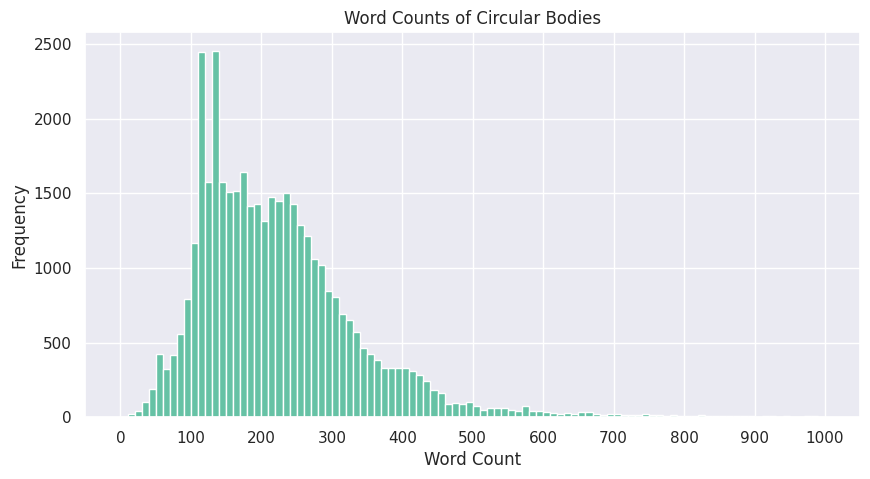

Number of circulars with > 1000 words: 318


In [6]:
'''
Get word count distribution over all circulars.
'''
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme()

counts=[]
for text in circular_bodies:
  counts.append(len(text.split()))

plt.figure(figsize=(10, 5))
plt.hist(counts, range=(0,1000), bins=100, color=sns.color_palette("Set2", 1))
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Word Counts of Circular Bodies")
plt.xticks(np.arange(0, 1001, 100))
plt.show()

counts_over_1000 = [count>1000 for count in counts]
print(f'Number of circulars with > 1000 words: {sum(counts_over_1000)}')

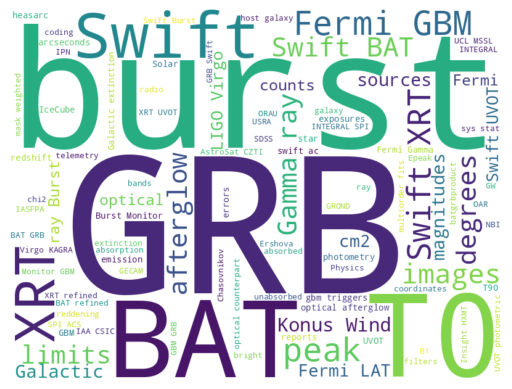

'\nPrint the list of words in the word cloud\n'

In [14]:
'''
Create word cloud over all GCN circulars.
Includes bigrams and trigrams of words.
'''
from wordcloud import WordCloud

word_cloud = WordCloud(
    collocations = True,
    background_color = 'white',
    max_words=100,
    width=800,
    height=600,
    stopwords=new_stop_words).generate(' '.join(circular_bodies))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

'''
Print the list of words in the word cloud
'''

# word_frequencies = word_cloud.words_
# words = list(word_frequencies.keys())
# for word in words:
#   print(word)

#circular_bodies = circular_bodies[35000:39000]


#Step 5: Compute sentence-transformer embeddings and save

In [8]:
'''
Embed our circulars using the base all-MiniLM-L6-v2 model.
'''
from sentence_transformers import SentenceTransformer

# Default model. Really fast, but only has context window of 256 tokens
model = SentenceTransformer("all-MiniLM-L6-v2")
minilm_l6_embeddings = model.encode(circular_bodies, show_progress_bar=True)
np.save('minilm_l6_embeddings.npy', minilm_l6_embeddings)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1266 [00:00<?, ?it/s]

#Step 6: Perform Topic Modelling

In [9]:
'''
Initialize Llama cpp model and AutoTokenizer
'''
from transformers import AutoTokenizer
from google.colab import userdata
from huggingface_hub import login
from llama_cpp import Llama

# Huggingface login required to use Mistral 7B Instruct
# Make sure to save your own Huggingface login token in your Notebook's Secrets as 'HF_LOGIN_TOKEN'
login_token = userdata.get('gcn-hf-1')
login(token=login_token)

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
llm = Llama(model_path="mistral-7b-instruct-v0.2.Q4_K_M.gguf",
            n_gpu_layers=-1,
            n_ctx=32768)

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: Tesla T4, compute capability 7.5, VMM: yes
llama_model_load_from_file_impl: using device CUDA0 (Tesla T4) - 14654 MiB free
llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from mistral-7b-instruct-v0.2.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32 

In [ ]:
'''
We will now perform topic modelling with BERTopic.
We use the default all-MiniLM-L6-v2 and a minimum topic size of 100 which gave the best coherence score for this model.
In addition, we will use a 4-bit quantized version of the new Mistral-7B-Instruct LLM for topic label generation.
This open sorce model has been shown to have superior performance to Llama 2 13B on multiple benchmarks.
It has been fine-tuned using publicly available conversation datasets.
'''
import time
import torch
import random
from bertopic.representation import LlamaCPP
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic

start_time = time.time()

# Set number of threads to 1 and set other os environment variables for reproducibility
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.set_num_threads(1)

seed_value = 42  # Set the random seed
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.use_deterministic_algorithms(True)

# Build representation model with mistral and llama cpp
# Use a custom prompt for label generation
prompt = """Q: I have a topic that contains the following representative circulars among hundreds of others:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic?
A: """

representation_model = LlamaCPP(model=llm,
                                prompt=prompt,
                                doc_length=768,
                                tokenizer=tokenizer,
                                pipeline_kwargs={"max_tokens": 128,
                                                 "stop": "Q:",
                                                 "temperature": 0.0})

embeddings = np.load("minilm_l6_embeddings.npy")

# Fix random state in UMAP for reproducibility
umap_model = UMAP(n_neighbors=35, # For balanced scientific topics (GW, GRB, Neutrino, Follow-up, etc.): 25–50
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  low_memory=False,
                  random_state=42) # fixed seed for reproducibility

# Set number of cores to one to turn off multi-threading. This should help with reproducibility.
# Set minimum cluster size to 400. This will iteratively merge smaller clusters to form bigger ones.
# Set minimum samples to 10. This will make sure only clusters smaller than 10 are treated as outliers.
hdbscan_model = HDBSCAN(min_cluster_size=800,
                        min_samples=10,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True,
                        core_dist_n_jobs=1)


# Build Topic Model with BERTopic
topic_model = BERTopic(verbose=True,
                       umap_model=umap_model,
                       hdbscan_model=hdbscan_model,
                       vectorizer_model=vectorizer_model)

topics, probs = topic_model.fit_transform(circular_bodies, embeddings)

# -----------------------
# Reduce to 10 Topics
# -----------------------
topic_model.reduce_topics(circular_bodies, nr_topics=10)

# Reuse the same embeddings when re-transforming
topics, probs = topic_model.transform(circular_bodies, embeddings=embeddings)

end_time = time.time()
print(end_time - start_time)

# Display topics
freq = topic_model.get_topic_info()
freq.head(30)

# Error Analysis
document_info = topic_model.get_document_info(circular_bodies)
document_info.head()

2025-10-07 06:21:50,076 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


In [97]:
'''
Apply t-SNE to reduce the dimensionality of the embeddings and visualize the clusters.
'''
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import itertools

# reduced_embeddings = UMAP(n_components=2, random_state=0).fit_transform(embeddings)
# reduced_embeddings = TSNE(n_components=2, n_jobs=1, random_state=0, verbose=2).fit_transform(embeddings)
reduced_embeddings = TSNE(
    n_components=2,
    n_jobs=1,
    random_state=42,
    verbose=2,
    learning_rate='auto',
    init='pca'
).fit_transform(embeddings)

fig = go.Figure()
tsne_df = pd.DataFrame()
tsne_df["x"], tsne_df["y"] = reduced_embeddings[:, 0], reduced_embeddings[:, 1]
tsne_df["topics"] = [topic_model.topic_labels_[i] for i in topics]

unique_topics = list(freq['Name'])[1:] # Exclude the outlier topic (-1) from unique topics
# light24 = px.colors.qualitative.Light24
# dark24 = px.colors.qualitative.Dark24
# colors = light24[0:11] + [dark24[9]] + dark24[5:8] + dark24[15:17] + [dark24[13]] + [light24[22]] + [light24[17]]
# color_cycle = itertools.cycle(colors)

palette = px.colors.qualitative.T10 + px.colors.qualitative.Vivid + px.colors.qualitative.Bold
color_cycle = itertools.cycle(palette)


for label in unique_topics:
    sub_df = tsne_df.loc[tsne_df["topics"] == label]
    fig.add_trace(
        go.Scattergl(
            x=sub_df["x"],
            y=sub_df["y"],
            mode="markers",
            name=str(label[label.find('_')+1:]) + " (" + str(sub_df.shape[0]) + ")",
            marker=dict(
                color=next(color_cycle),
                size=5,
                opacity=0.5,
            )
        )
    )

fig.update_traces(
  marker=dict(
    size=6,
    opacity=0.5,
  )
)

fig.update_layout(
  # title={
  #   'text': "<b>General Coordinates Network (GCN): Key Astrophysical Topics</b>",
  #   'x': 0.5,
  #   'xanchor': 'center'
  # },
  width=1600,
  height=800,
  legend_title_text="Topics (Circular Counts)",
  legend=dict(
    x=1.05,
    y=1,
    traceorder='normal',
    bgcolor='rgba(0,0,0,0)',
    bordercolor='rgba(0,0,0,0)',
    font=dict(
            size=18  # increase this value to make names larger
        )
  ),
  xaxis=dict(
    showticklabels=False
  ),
  yaxis=dict(
    showticklabels=False
  )
)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 40506 samples in 0.010s...
[t-SNE] Computed neighbors for 40506 samples in 47.039s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40506
[t-SNE] Computed conditional probabilities for sample 2000 / 40506
[t-SNE] Computed conditional probabilities for sample 3000 / 40506
[t-SNE] Computed conditional probabilities for sample 4000 / 40506
[t-SNE] Computed conditional probabilities for sample 5000 / 40506
[t-SNE] Computed conditional probabilities for sample 6000 / 40506
[t-SNE] Computed conditional probabilities for sample 7000 / 40506
[t-SNE] Computed conditional probabilities for sample 8000 / 40506
[t-SNE] Computed conditional probabilities for sample 9000 / 40506
[t-SNE] Computed conditional probabilities for sample 10000 / 40506
[t-SNE] Computed conditional probabilities for sample 11000 / 40506
[t-SNE] Computed conditional probabilities for sample 12000 / 40506
[t-SNE] Computed conditional probabilities for sa

In [98]:
'''
Generate topic summaries with Mistral 7B Instruct and update representations
'''

topic_model.update_topics(circular_bodies,
                          representation_model=representation_model)


  0%|          | 0/9 [00:00<?, ?it/s]Llama.generate: 28 prefix-match hit, remaining 3067 prompt tokens to eval
llama_perf_context_print:        load time =    4357.63 ms
llama_perf_context_print: prompt eval time =    3815.62 ms /  3067 tokens (    1.24 ms per token,   803.80 tokens per second)
llama_perf_context_print:        eval time =    1237.19 ms /    32 runs   (   38.66 ms per token,    25.86 tokens per second)
llama_perf_context_print:       total time =    5070.26 ms /  3099 tokens
 11%|█         | 1/9 [00:05<00:40,  5.09s/it]Llama.generate: 31 prefix-match hit, remaining 2785 prompt tokens to eval
llama_perf_context_print:        load time =    4357.63 ms
llama_perf_context_print: prompt eval time =    3379.74 ms /  2785 tokens (    1.21 ms per token,   824.03 tokens per second)
llama_perf_context_print:        eval time =     882.60 ms /    23 runs   (   38.37 ms per token,    26.06 tokens per second)
llama_perf_context_print:       total time =    4276.73 ms /  2808 tokens


In [99]:
# Display topic summaries
freq = topic_model.get_topic_info()
freq.head(20)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4810,-1_ AstroSat CZTI Detections of GRBs by Fermi-...,[ AstroSat CZTI Detections of GRBs by Fermi-GB...,[GRB 230911B: AstroSat CZTI detectionP. K. Nav...
1,0,16335,0_ GRB Observations: GROND Detection and Magni...,[ GRB Observations: GROND Detection and Magnit...,"[GRB 140801A: GROND Afterglow detection, unbro..."
2,1,4377,1_ Swift Detection of Gamma-Ray Bursts: BAT Tr...,[ Swift Detection of Gamma-Ray Bursts: BAT Tri...,[GRB 091029: Swift detection of a burst with a...
3,2,3699,2_ LIGO/Virgo/KAGRA Compact Binary Merger Cand...,[ LIGO/Virgo/KAGRA Compact Binary Merger Candi...,[IceCube-220822A - IceCube observation of a hi...
4,3,3007,3_ Swift-XRT Analysis of GRB Light Curves and ...,[ Swift-XRT Analysis of GRB Light Curves and S...,[GRB 090123: Swift XRT refined analysisD. Grup...
5,4,2348,4_\nGlobal MASTER-Net Observations of Swift GR...,[\nGlobal MASTER-Net Observations of Swift GRB...,[Fermi trigger No 762963055: Global MASTER-Ne...
6,5,2080,"5_ Fermi GBM Observations: GRB Detections, Loc...","[ Fermi GBM Observations: GRB Detections, Loca...",[GRB 200716C: Fermi GBM detectionP. Veres (UAH...
7,6,2023,6_ Konus-Wind Observations of Long-Duration Ga...,[ Konus-Wind Observations of Long-Duration Gam...,"[IPN triangulation of GRB 250201AA.S. Kozyrev,..."
8,7,1827,7_ Swift/UVOT Upper Limits: GRB Detections and...,[ Swift/UVOT Upper Limits: GRB Detections and ...,[GRB 130131B: Swift/UVOT Upper LimitsM. H. Sie...


In [100]:
'''
Get table with just Topic Summaries and Frequencies
'''
sub_freq = freq[['Representation', 'Count']].copy()
sub_freq['Topic Summary'] = freq['Representation'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
sub_freq['Circular Count'] = freq['Count']
sub_freq.drop('Representation', axis=1, inplace=True)
sub_freq.drop('Count', axis=1, inplace=True)

sub_freq.drop(index=0, inplace=True) # Drop outlier row
sub_freq

sub_freq.to_csv('Unsupervised_Astrophysical_Topics.csv', index=False)

In [ ]:
latex_table = sub_freq.to_latex(index=False)
latex_table

'''
Visualise topics in a 2-D space using UMAP
'''
topic_model.visualize_topics()

In [ ]:
'''
Perform hierarchical reduction on our topic model.
Viualize these hierarchies to better understand the relations between our topics.
'''

hierarchical_topics = topic_model.hierarchical_topics(circular_bodies)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
'''
Visualize hierarchical topic clusters
'''
topic_model.visualize_hierarchical_documents(circular_bodies, hierarchical_topics, embeddings=embeddings, topics=list(range(10)))

'''
Display a Similarity Matrix for all Topics
'''
topic_model.visualize_heatmap(topics=list(range(10)), width=650, height=650)

In [ ]:
'''
Create word cloud over top 10 topics
'''

fig, axs = plt.subplots(10, 1, figsize=(10, 80)) # Create a figure with 10 subplots vertically arranged

# Join all documents of a topic together and generate word cloud
for topic_num, ax in enumerate(axs):
    word_cloud = WordCloud(
        collocations=True,
        background_color='white',
        max_words=100,
        width=1000,
        height=800,
        stopwords=new_stop_words).generate(' '.join([text for i, text in enumerate(circular_bodies) if topics[i] == topic_num]))

    ax.imshow(word_cloud, interpolation='bilinear')
    ax.set_title(topic_model.topic_representations_[topic_num][0][0])
    ax.axis("off")

plt.subplots_adjust(hspace=0.5)
plt.show()

#Step 7: Trend Analysis

/tmp/ipython-input-2075674957.py:35: DeprecationWarning:

datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).

/tmp/ipython-input-2075674957.py:34: DeprecationWarning:

datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).

/tmp/ipython-input-2075674957.py:35: DeprecationWarning:

datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).

/tmp/ipython-input-2075674957.py:34: DeprecationWarning:

datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware object

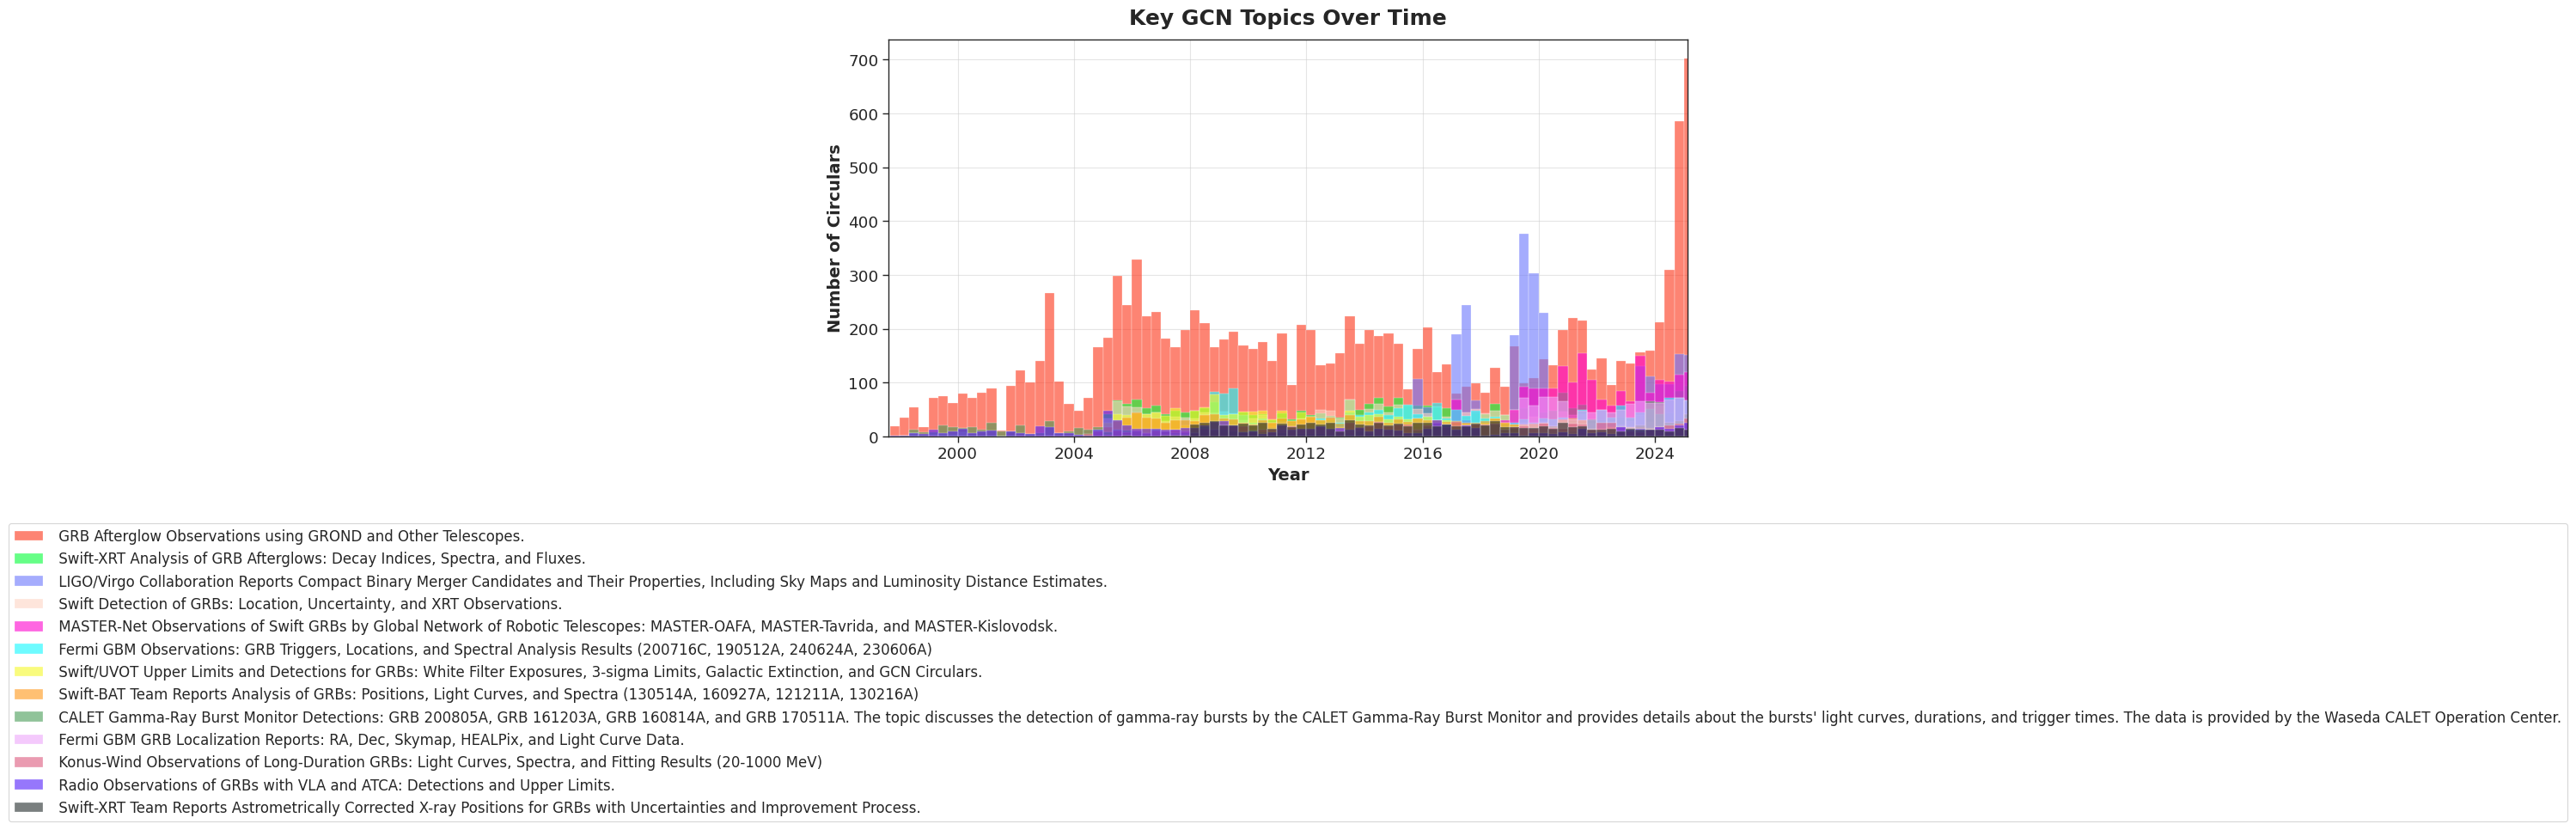

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import itertools
from datetime import datetime
import plotly.express as px

num_topics = len(freq) - 1  # Exclude outlier row

# Plot style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

# Modern color palette
light24 = px.colors.qualitative.Light24
dark24 = px.colors.qualitative.Dark24
colors = light24[0:11] + dark24[5:10]
color_cycle = itertools.cycle(colors)

fig, ax = plt.subplots(figsize=(14, 6))

for k in range(num_topics):
    topic_dates = []

    for i, ts in enumerate(time_stamps):
        if ts == 0:  # Skip invalid timestamps
            continue
        if topics[i] == k:
            topic_dates.append(datetime.utcfromtimestamp(ts / 1000))

    if len(topic_dates) == 0:
        continue  # Skip empty topics

    # Binning by 4 months
    all_dates = [datetime.utcfromtimestamp(ts / 1000) for ts in time_stamps if ts != 0]
    bins = pd.date_range(start=min(all_dates), end=max(all_dates), freq='4M')

    # Use top 3 words as topic label
    top_words = topic_model.get_topic(k)
    if top_words is not None:
        label_str = ", ".join([w for w, _ in top_words[:3]])
    else:
        label_str = f"Topic {k}"

    sns.histplot(topic_dates,
                 bins=mdates.date2num(bins),
                 alpha=0.6,
                 linewidth=0.2,
                 color=next(color_cycle),
                 ax=ax,
                 label=label_str)

# X-axis formatting
ax.set_xlim(min(all_dates), max(all_dates))
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel("Year", fontsize=14, fontweight="bold")
plt.ylabel("Number of Circulars", fontsize=14, fontweight="bold")
plt.title("Key GCN Topics Over Time", fontsize=18, fontweight="bold", y=1.02)

# Grid and legend
plt.grid(axis="both", linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', fontsize=12, ncol=3)

plt.tight_layout()
plt.show()


/tmp/ipython-input-4003598178.py:27: DeprecationWarning:

datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).

/tmp/ipython-input-4003598178.py:24: DeprecationWarning:

datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).



KeyError: 14

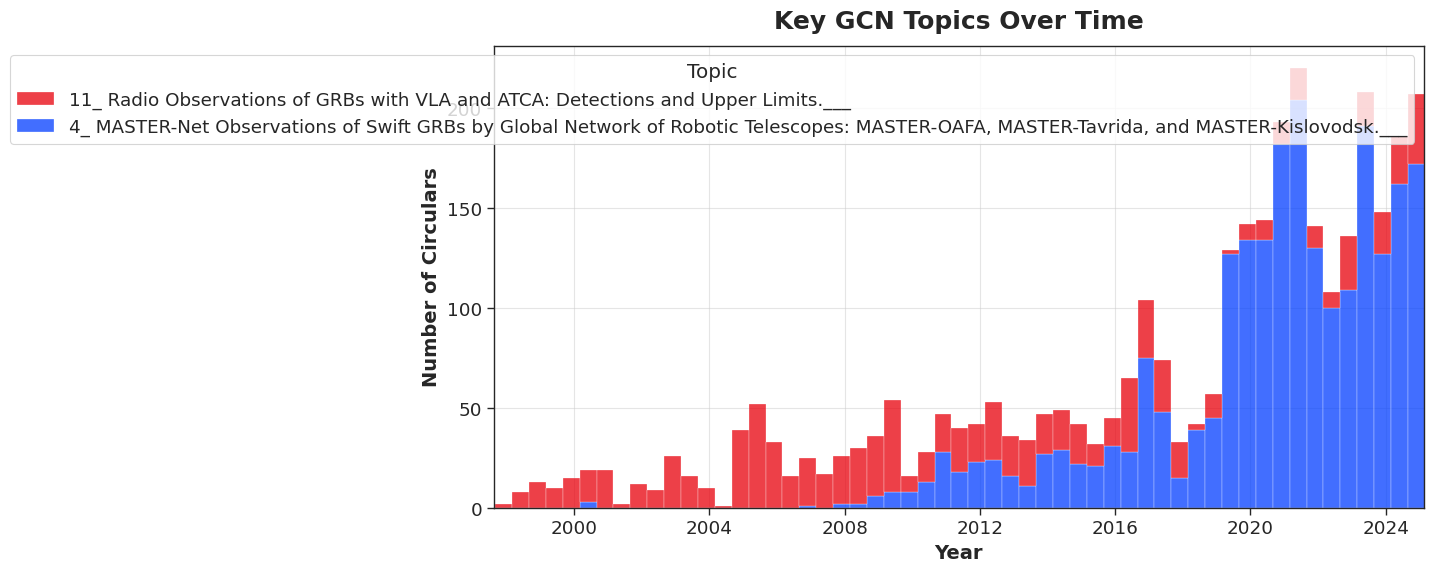

In [80]:
from matplotlib.patches import Patch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime

# Select key topics
important_topics_list = [4, 11, 14, 22]

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

# Modern, distinct colors
custom_colors = ['#e8000b', '#023eff', '#ff7c00', '#1ac938']
custom_palette = sns.color_palette(custom_colors)

fig, ax = plt.subplots(figsize=(14, 6))

all_topic_dates = []
all_dates = []

# Collect topic dates
for i, ts in enumerate(time_stamps):
    if ts == 0:
        continue
    date = datetime.utcfromtimestamp(ts / 1000)
    all_dates.append(date)
    if topics[i] in important_topics_list:
        topic = topic_model.topic_labels_[topics[i]]
        all_topic_dates.append({'Date': date, 'Topic': topic})

topic_dates_df = pd.DataFrame(all_topic_dates)

# 6-month bins
bins = pd.date_range(start=min(all_dates), end=max(all_dates), freq='6M')

# Plot stacked histogram
sns.histplot(topic_dates_df,
             x='Date',
             hue='Topic',
             multiple='stack',
             bins=mdates.date2num(bins),
             alpha=0.75,
             linewidth=0.2,
             palette=custom_palette,
             ax=ax)

# X-axis formatting
ax.set_xlim(min(all_dates), max(all_dates))
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel("Year", fontsize=14, fontweight="bold")
plt.ylabel("Number of Circulars", fontsize=14, fontweight="bold")
plt.title("Selected Key GCN Topics Over Time", fontsize=18, fontweight="bold", y=1.02)

# Grid & legend
plt.grid(axis="both", linestyle="--", alpha=0.5)
handles = [Patch(color=custom_colors[i],
                 label=", ".join([w for w, _ in topic_model.get_topic(important_topics_list[i])[:3]]))
           for i in range(len(important_topics_list))]
plt.legend(handles=handles, bbox_to_anchor=(0.01, 0.99), loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()
